# Evaluating Entropies in tfSF (Simulation 1)

In this notebook we examine entropies in the original data and in learned representations, repurposing some of the experiments in [1].

## Setup

We start by importing some libraries:

In [1]:
import numpy as np
import joblib
import sklearn.datasets as ds
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import linregress

import tfSF
import npSF

import data.data_creation as D
from IT import IT,npeet

We define the parameters of our simulation:

In [2]:
learned_features = 2
n_epochs = 200

We define a couple of helper functions: a simple linear regression function and a helper function to compute the tfSF learned representation as a function of the weights. Notice that here, for simplicity, we call the steps of SF implemented using *numpy*; since no learning is now required, using *numpy* saves us the overhead of instantiating a *tensorflow* model.

In [3]:
def linreg(x,y):
    a, b, _, _, _ = stats.linregress(x,y)
    return a*x+b
    

def computeZ(X,W):
    WX = np.dot(W,X.T)
    F = npSF.softabsolute(WX)
    Fsquish, _ = npSF.l2row(F)
    Fhat, _ = npSF.l2row(Fsquish.T)
    Z = Fhat
    return Z

## Simulation 1 from [1]

We use *Simulation 1* in [1], and we run a tfSF module varying the number of training points and the number of bins to estimate entropy. We estimate entropy using both the *binning method* and the *npeet method*.

In [8]:
n_simulations = 1

original_features = 2
learned_features = 2
n_samples = [2,3,4,5,6,7,8,9,10,12,15,20,25,30,50,100]
n_epochs = 200
n_bins = [10,20,30,40,50]
    
maxX = 5; minX = -5   

IT_dataH = np.zeros((len(n_samples),n_simulations,len(n_bins)))
IT_results = np.zeros((len(n_samples),n_simulations,n_epochs,len(n_bins)))

npeet_discr_dataH = np.zeros((len(n_samples),n_simulations))
npeet_discr_results = np.zeros((len(n_samples),n_simulations,n_epochs))

npeet_cont_dataH = np.zeros((len(n_samples),n_simulations))
npeet_cont_results = np.zeros((len(n_samples),n_simulations,n_epochs))

for i,n_samp in enumerate(n_samples):
    
    print('Samples {0}'.format(n_samp))
    for j in tqdm(range(n_simulations)):
        data = D.get_samples_independent_gaussians_2D(n_samples_train=n_samp, n_samples_test=2, mu1 = 0.0, sigma1 = .5, mu2 = 0.0, sigma2 =.5)
        
        X = data['X_tr']
        k = np.min([3,n_samp-1])
        for b,IT_bins in enumerate(n_bins):
            IT_dataH[i,j,b] = IT.compute_H_bin(X,bins=IT_bins)
        npeet_discr_dataH[i,j] = npeet.entropyd(X)
        npeet_cont_dataH[i,j] = npeet.entropy(X,k)
        
        tfsf = tfSF.SFilter(n_features=learned_features)
        tfsf.fit(X,epochs=n_epochs,verbose=0,batchsize=n_samp)
        
        Ws = tfsf.weights
        for e in range(n_epochs):
            Z = computeZ(X,Ws[e])
            for b,IT_bins in enumerate(n_bins):    
                IT_results[i,j,e,b] = IT.compute_H_bin(Z,bins=IT_bins)
            npeet_discr_results[i,j] = npeet.entropyd(Z)
            npeet_cont_results[i,j] = npeet.entropy(Z,k)

  0%|          | 0/1 [00:00<?, ?it/s]

Samples 2


  0%|          | 0/1 [00:00<?, ?it/s]

Samples 3


  0%|          | 0/1 [00:00<?, ?it/s]

Samples 4


  0%|          | 0/1 [00:00<?, ?it/s]

Samples 5


  0%|          | 0/1 [00:00<?, ?it/s]

Samples 6


  0%|          | 0/1 [00:00<?, ?it/s]

Samples 7


  0%|          | 0/1 [00:00<?, ?it/s]

Samples 8


  0%|          | 0/1 [00:00<?, ?it/s]

Samples 9


  0%|          | 0/1 [00:00<?, ?it/s]

Samples 10


  0%|          | 0/1 [00:00<?, ?it/s]

Samples 12


  0%|          | 0/1 [00:00<?, ?it/s]

Samples 15


  0%|          | 0/1 [00:00<?, ?it/s]

Samples 20


  0%|          | 0/1 [00:00<?, ?it/s]

Samples 25


  0%|          | 0/1 [00:00<?, ?it/s]

Samples 30


  0%|          | 0/1 [00:00<?, ?it/s]

Samples 50


  0%|          | 0/1 [00:00<?, ?it/s]

Samples 100


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


### Base entropies

We then plot te entropy of the original data, the learned representations and the theoretical maximum.

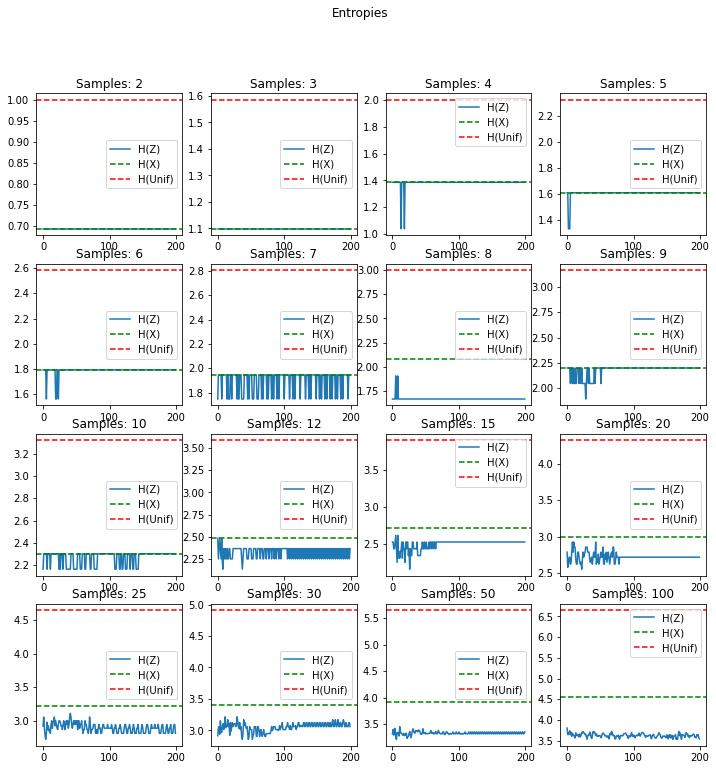

In [9]:
fig,ax = plt.subplots(4,4, figsize=(12,12))
fig.suptitle('Entropies')

for i in range(len(n_samples)):
    h_unif = -np.log2(1./n_samples[i])
    ax[i//4,i%4].plot(IT_results[i,0,:,2],label='H(Z)')
    ax[i//4,i%4].axhline(IT_dataH[i,0,2],color='green',linestyle='--',label='H(X)')
    ax[i//4,i%4].axhline(h_unif ,color='red',linestyle='--',label='H(Unif)')
    ax[i//4,i%4].set_title('Samples: {0}'.format(n_samples[i]))
    ax[i//4,i%4].legend()

### Assessing the estimation of entropy on the number of bins

Next, we observe how the estimation of the entropy changes with the number of bins.

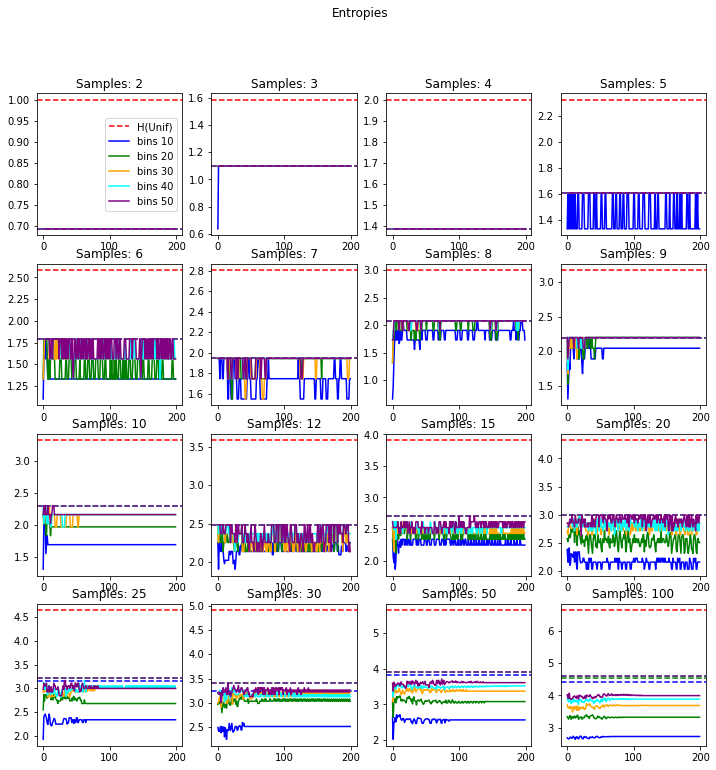

In [10]:
fig,ax = plt.subplots(4,4, figsize=(12,12))
fig.suptitle('Entropies')

for i in range(len(n_samples)):
    h_unif = -np.log2(1./n_samples[i])
    ax[i//4,i%4].axhline(h_unif ,color='red',linestyle='--',label='H(Unif)')
    ax[i//4,i%4].set_title('Samples: {0}'.format(n_samples[i]))
    
    colors = ['blue','green','orange','cyan','purple']
    for b in range(len(n_bins)):
        ax[i//4,i%4].plot(results[i,0,:,b],color=colors[b],label='bins {0}'.format(n_bins[b]))
        ax[i//4,i%4].axhline(dataH[i,0,b],color=colors[b],linestyle='--')
    if(i==0):
        ax[i//4,i%4].legend()

### Assessing the npeet estimation of entropy

We compare estimates of the *binning method* to *npeet*.

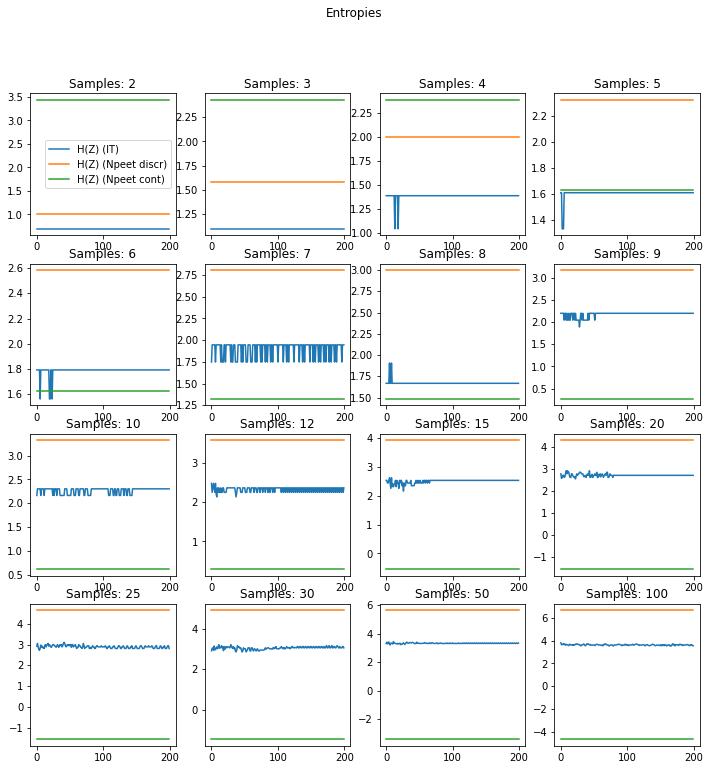

In [15]:
fig,ax = plt.subplots(4,4, figsize=(12,12))
fig.suptitle('Entropies')

for i in range(len(n_samples)):
    h_unif = -np.log2(1./n_samples[i])
    ax[i//4,i%4].plot(IT_results[i,0,:,2],label='H(Z) (IT)')
    ax[i//4,i%4].plot(npeet_discr_results[i,0,:],label='H(Z) (Npeet discr)')
    ax[i//4,i%4].plot(npeet_cont_results[i,0,:],label='H(Z) (Npeet cont)')
    
    #ax[i//4,i%4].axhline(IT_dataH[i,0,2],linestyle='--',label='H(X) (IT)')
    #ax[i//4,i%4].axhline(npeet_discr_dataH[i,0],linestyle='--',label='H(X) (Npeet discr)')
    #ax[i//4,i%4].axhline(npeet_cont_dataH[i,0],linestyle='--',label='H(X) (Npeet cont)')    
    
    #ax[i//4,i%4].axhline(h_unif ,color='red',linestyle='--',label='H(Unif)')
       
    ax[i//4,i%4].set_title('Samples: {0}'.format(n_samples[i]))
    
    if(i==0):
        ax[i//4,i%4].legend()

## Conclusions

- in 2D learned representations seem to have lower entropy that original data (but this may be effect of how original data has been generated)
- for (2D -> 2D) and the range of datapoints considered 30 bins seem a reasonable choice
- *npeet* does not seem to return meaningful estimates (need to debug why).

### References

[1] Zennaro, F.M. and Chen, K., 2019. Towards Further Understanding of Sparse Filtering via Information Bottleneck. arXiv preprint arXiv:1910.08964.